In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
import matplotlib as mpl
from IPython import display
from collections import OrderedDict
from pathlib import Path
import urllib.request

In [2]:
METRICS_OF_INTEREST = ["ESM-1v", "ProteinMPNN"]#, "longest_repeat_1", "longest_repeat_2"]

MODEL_HUE_ORDER = ["test", "ASR", "GAN", "ESM-MSA"]

In [3]:
def pass_filter(row):
  
    #starts with M filter
    if row["Generated_Sequence"][0]!= "M":
        return False
    if row["phobius_tm_count"] >= 1:
        return False
    if row["longest_repeat_1"] < -3: #-3
        return False
    if row["longest_repeat_2"] < -2: #-2
        return False
    
    return True


def map_model(model):
    parts = model.split("-")
    if len(parts) == 1:
        return model
    elif "ESM-MSA" in model:
        return "ESM-MSA"
    else:
        return "-".join(model.split("-")[:-1])


In [4]:
metrics_path = Path("../data/experimentally_tested_metrics.csv")

if not metrics_path.exists():
    urllib.request.urlretrieve("https://zenodo.org/records/10594384/files/experimentally_tested_metrics.csv", metrics_path)

experimentally_tested_metrics = pd.read_csv(metrics_path)


metrics_path = Path("../data/CM_table.csv")
if not metrics_path.exists():
    urllib.request.urlretrieve("https://zenodo.org/record/7808981/files/CM_table.csv", metrics_path)
CM_df = pd.read_csv(metrics_path)
CM_df["Family_name"] = "Chorismate mutase"

metrics_path = Path("../data/lysozyme_table.csv")
if not metrics_path.exists():
    urllib.request.urlretrieve("https://zenodo.org/record/7808981/files/lysozyme_table.csv", metrics_path)
lysozyme_df = pd.read_csv(metrics_path)
lysozyme_df = lysozyme_df.dropna(subset=["Activity"],axis='rows')


Index(['id', 'Family', 'Model', 'Round', 'Activity',
       'Closest training sequence', 'Identity', 'PFASUM15', 'MIF-ST',
       'ESM-MSA', 'ProteinMPNN', 'ESM-IF', 'CARP-640m', 'ESM-1v mask6',
       'AlphaFold2 pLDDT', 'ESM-1v', 'Rosetta-relax', 'BLOSUM62',
       'longest_repeat_1', 'longest_repeat_2', 'longest_repeat_3',
       'longest_repeat_4', 'phobius_tm_count', 'phobius_has_signal', 'sasa',
       'polar_sasa', 'apolar_sasa', 'percent_polar_sasa', 'net_charge',
       'abs_net_charge', 'Charged fraction', 'length',
       'phmmer_top_30_avg_score', 'Sequence', 'Generated_Sequence',
       'Quality checks pass'],
      dtype='object')

In [7]:
esm1v_cutoffs = {'CuSOD': -0.111278511583805, 'MDH': -0.1379929780960083}
MPNN_cutoffs = {'GAN': {'CuSOD': -1.1572, 'MDH': -1.3644}, 'ESM-MSA': {'CuSOD': -1.0861, 'MDH': -1.2315}}

model_colors = {'GAN': "#2ca02c", 'ESM-MSA': '#d62728'}

In [12]:
def calculate_quantile_stats(df, esm_1v_lb, esm_1v_ub, MPNN_lb, MPNN_ub):
    sub_df = df[(df["ProteinMPNN"] >= MPNN_lb) & (df["ProteinMPNN"] < MPNN_ub) ]
    out = None
    # print("\n\n")
    # print(f"MPNN bounds: {MPNN_lb}, {MPNN_ub}")
    # print(f"MPNN_i: {MPNN_i},  ESM-1v_i: {ESM_i}")
    sub_df = sub_df[(sub_df["ESM-1v"] >= esm_1v_lb) & (sub_df["ESM-1v"] < esm_1v_ub)]
    if len(sub_df) > 0:
        out = {"MPNN_AUC": None, "ESM_AUC": None, "Spearman": None, "Positives": None, "Negatives": None, "Rate":None}
        # print(f"ESM-1v bounds: {esm_1v_lb}, {esm_1v_ub}")
        # print(f"df_size: {len(sub_df)}")

        AUCs = dict()
        for metric in ["ProteinMPNN", "ESM-1v"]:
            fpr, tpr, _ = roc_curve(sub_df['Activity'], sub_df[metric])
            AUCs[metric] = auc(fpr, tpr)

        # print(f"MPNN AUC: {AUCs['ProteinMPNN']}")
        # print(f"ESM AUC: {AUCs['ESM-1v']}")
        out["MPNN_AUC"] = AUCs['ProteinMPNN']
        out["ESM_AUC"] = AUCs['ESM-1v']

        spearman = sub_df[["ProteinMPNN", "ESM-1v"]].corr("spearman")["ESM-1v"]["ProteinMPNN"]
        #print(spearman)
        out["Spearman"] = spearman
        
        positives = len(sub_df[sub_df["Activity"] == 1])
        negatives = len(sub_df[sub_df["Activity"] == 0])
        rate = positives/(positives+negatives)
        # print(f"Positives: {positives}")
        # print(f"Negatives: {negatives}")
        # print(f"Rate: {rate}")
        out["Positives"] = positives
        out["Negatives"] = negatives
        out["Rate"] = round(100*rate)
        
    return out
    

def plot_quarters(df, ax, title_base, hue_order=MODEL_HUE_ORDER):
    
    
    sns.scatterplot(x="ESM-1v", y="ProteinMPNN", style="Activity",  hue="Model", style_order=[0,1], alpha=0.8, hue_order=hue_order, data=df, ax=ax)

    MPNN_median = df["ProteinMPNN"].median()
    MPNN_min = df["ProteinMPNN"].min()
    MPNN_max = df["ProteinMPNN"].max()
    ax.axhline(MPNN_median, color="grey", linestyle="--")
    
    ESM_median =  df["ESM-1v"].median()
    ESM_min = df["ESM-1v"].min()
    ESM_max = df["ESM-1v"].max()
    
    ax.axvline(ESM_median, color="grey", linestyle="--")

    MPNN_quantiles = [float("-inf"), MPNN_median, float("inf")]
    ESM_quantiles  = [float("-inf"), ESM_median, float("inf")]
    
    draw_coords = {(1,1): (ESM_min, MPNN_median), # lower_left
                   (1,2): (ESM_median, MPNN_median), # lower_right
                   (2,1): (ESM_min, MPNN_max), # upper_left
                   (2,2): (ESM_median, MPNN_max), # upper_right
                  }
    
    
    for MPNN_i in range(1, 3):
        MPNN_lb = MPNN_quantiles[MPNN_i - 1]
        MPNN_ub = MPNN_quantiles[MPNN_i]
        for ESM_i in range(1, 3):
            esm_lb = ESM_quantiles[ESM_i - 1]
            esm_ub = ESM_quantiles[ESM_i]
            quantile_stats = calculate_quantile_stats(df,esm_lb,esm_ub,MPNN_lb,MPNN_ub)
            if quantile_stats is not None:
                ax.text(*draw_coords[(MPNN_i, ESM_i)], f"ProteinMPNN AUC: {quantile_stats['MPNN_AUC']:0.2f}\nESM-1v AUC: {quantile_stats['ESM_AUC']:0.2f}\nSpearman corr.: {quantile_stats['Spearman']:0.2f}\nActive: {quantile_stats['Positives']} of {quantile_stats['Positives'] + quantile_stats['Negatives']} ({quantile_stats['Rate']}%)",
                       va='top', ha='left', alpha=0.7)
    # out["Positives"] = positives
    # out["Negatives"] = negatives
    # out["Rate"] = rate
    
    MPNN_lb = float("-inf")
    MPNN_ub = float("inf")
    esm_lb = float("-inf")
    esm_ub = float("inf")
    quantile_stats = calculate_quantile_stats(df,esm_lb,esm_ub,MPNN_lb,MPNN_ub)
    if quantile_stats is not None:
        ax.set_title(title_base + "\n"+
                    f"ProteinMPNN AUC: {quantile_stats['MPNN_AUC']:0.2f}\nESM-1v AUC: {quantile_stats['ESM_AUC']:0.2f}\nSpearman corr.: {quantile_stats['Spearman']:0.2f}\nActive: {quantile_stats['Positives']} of {quantile_stats['Positives'] + quantile_stats['Negatives']} ({quantile_stats['Rate']}%)"                
                    )
    ax.get_legend().remove()
    

def plot_halves(df, ax, title_base, hue_order=MODEL_HUE_ORDER):
    
    
    sns.scatterplot(x="ESM-1v", y="ProteinMPNN", style="Activity",  hue="Model", style_order=[0,1], alpha=0.8, hue_order=hue_order, data=df, ax=ax)

    MPNN_median = df["ProteinMPNN"].median()
    MPNN_min = df["ProteinMPNN"].min()
    MPNN_max = df["ProteinMPNN"].max()
    ax.axhline(MPNN_median, color="grey", linestyle="--")
    
    ESM_median =  df["ESM-1v"].median()
    ESM_min = df["ESM-1v"].min()
    ESM_max = df["ESM-1v"].max()
    # ax.axvline(ESM_median, color="grey", linestyle="--")

    MPNN_quantiles = [float("-inf"), MPNN_median, float("inf")]
    ESM_quantiles  = [float("-inf"), ESM_median, float("inf")]
    
    draw_coords = {1: (ESM_min, MPNN_median), # low
                   2: (ESM_min, MPNN_max), # high
                  }
    
    
    for MPNN_i in range(1, 3):
        MPNN_lb = MPNN_quantiles[MPNN_i - 1]
        MPNN_ub = MPNN_quantiles[MPNN_i]
        quantile_stats = calculate_quantile_stats(df,float("-inf"),float("inf"),MPNN_lb,MPNN_ub)
        if quantile_stats is not None:
            ax.text(*draw_coords[MPNN_i], f"ProteinMPNN AUC: {quantile_stats['MPNN_AUC']:0.2f}\nESM-1v AUC: {quantile_stats['ESM_AUC']:0.2f}\nSpearman corr.: {quantile_stats['Spearman']:0.2f}\nActive: {quantile_stats['Positives']} of {quantile_stats['Positives'] + quantile_stats['Negatives']} ({quantile_stats['Rate']}%)",
                   va='top', ha='left', alpha=0.7)
    # out["Positives"] = positives
    # out["Negatives"] = negatives
    # out["Rate"] = rate
    
    MPNN_lb = float("-inf")
    MPNN_ub = float("inf")
    esm_lb = float("-inf")
    esm_ub = float("inf")
    quantile_stats = calculate_quantile_stats(df,esm_lb,esm_ub,MPNN_lb,MPNN_ub)
    if quantile_stats is not None:
        ax.set_title(title_base + "\n"+
                    f"ProteinMPNN AUC: {quantile_stats['MPNN_AUC']:0.2f}\nESM-1v AUC: {quantile_stats['ESM_AUC']:0.2f}\nSpearman corr.: {quantile_stats['Spearman']:0.2f}\nActive: {quantile_stats['Positives']} of {quantile_stats['Positives'] + quantile_stats['Negatives']} ({quantile_stats['Rate']}%)"                
                    )
    ax.get_legend().remove()

/home/sean/miniconda3/envs/protein_scoring/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/home/sean/miniconda3/envs/protein_scoring/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


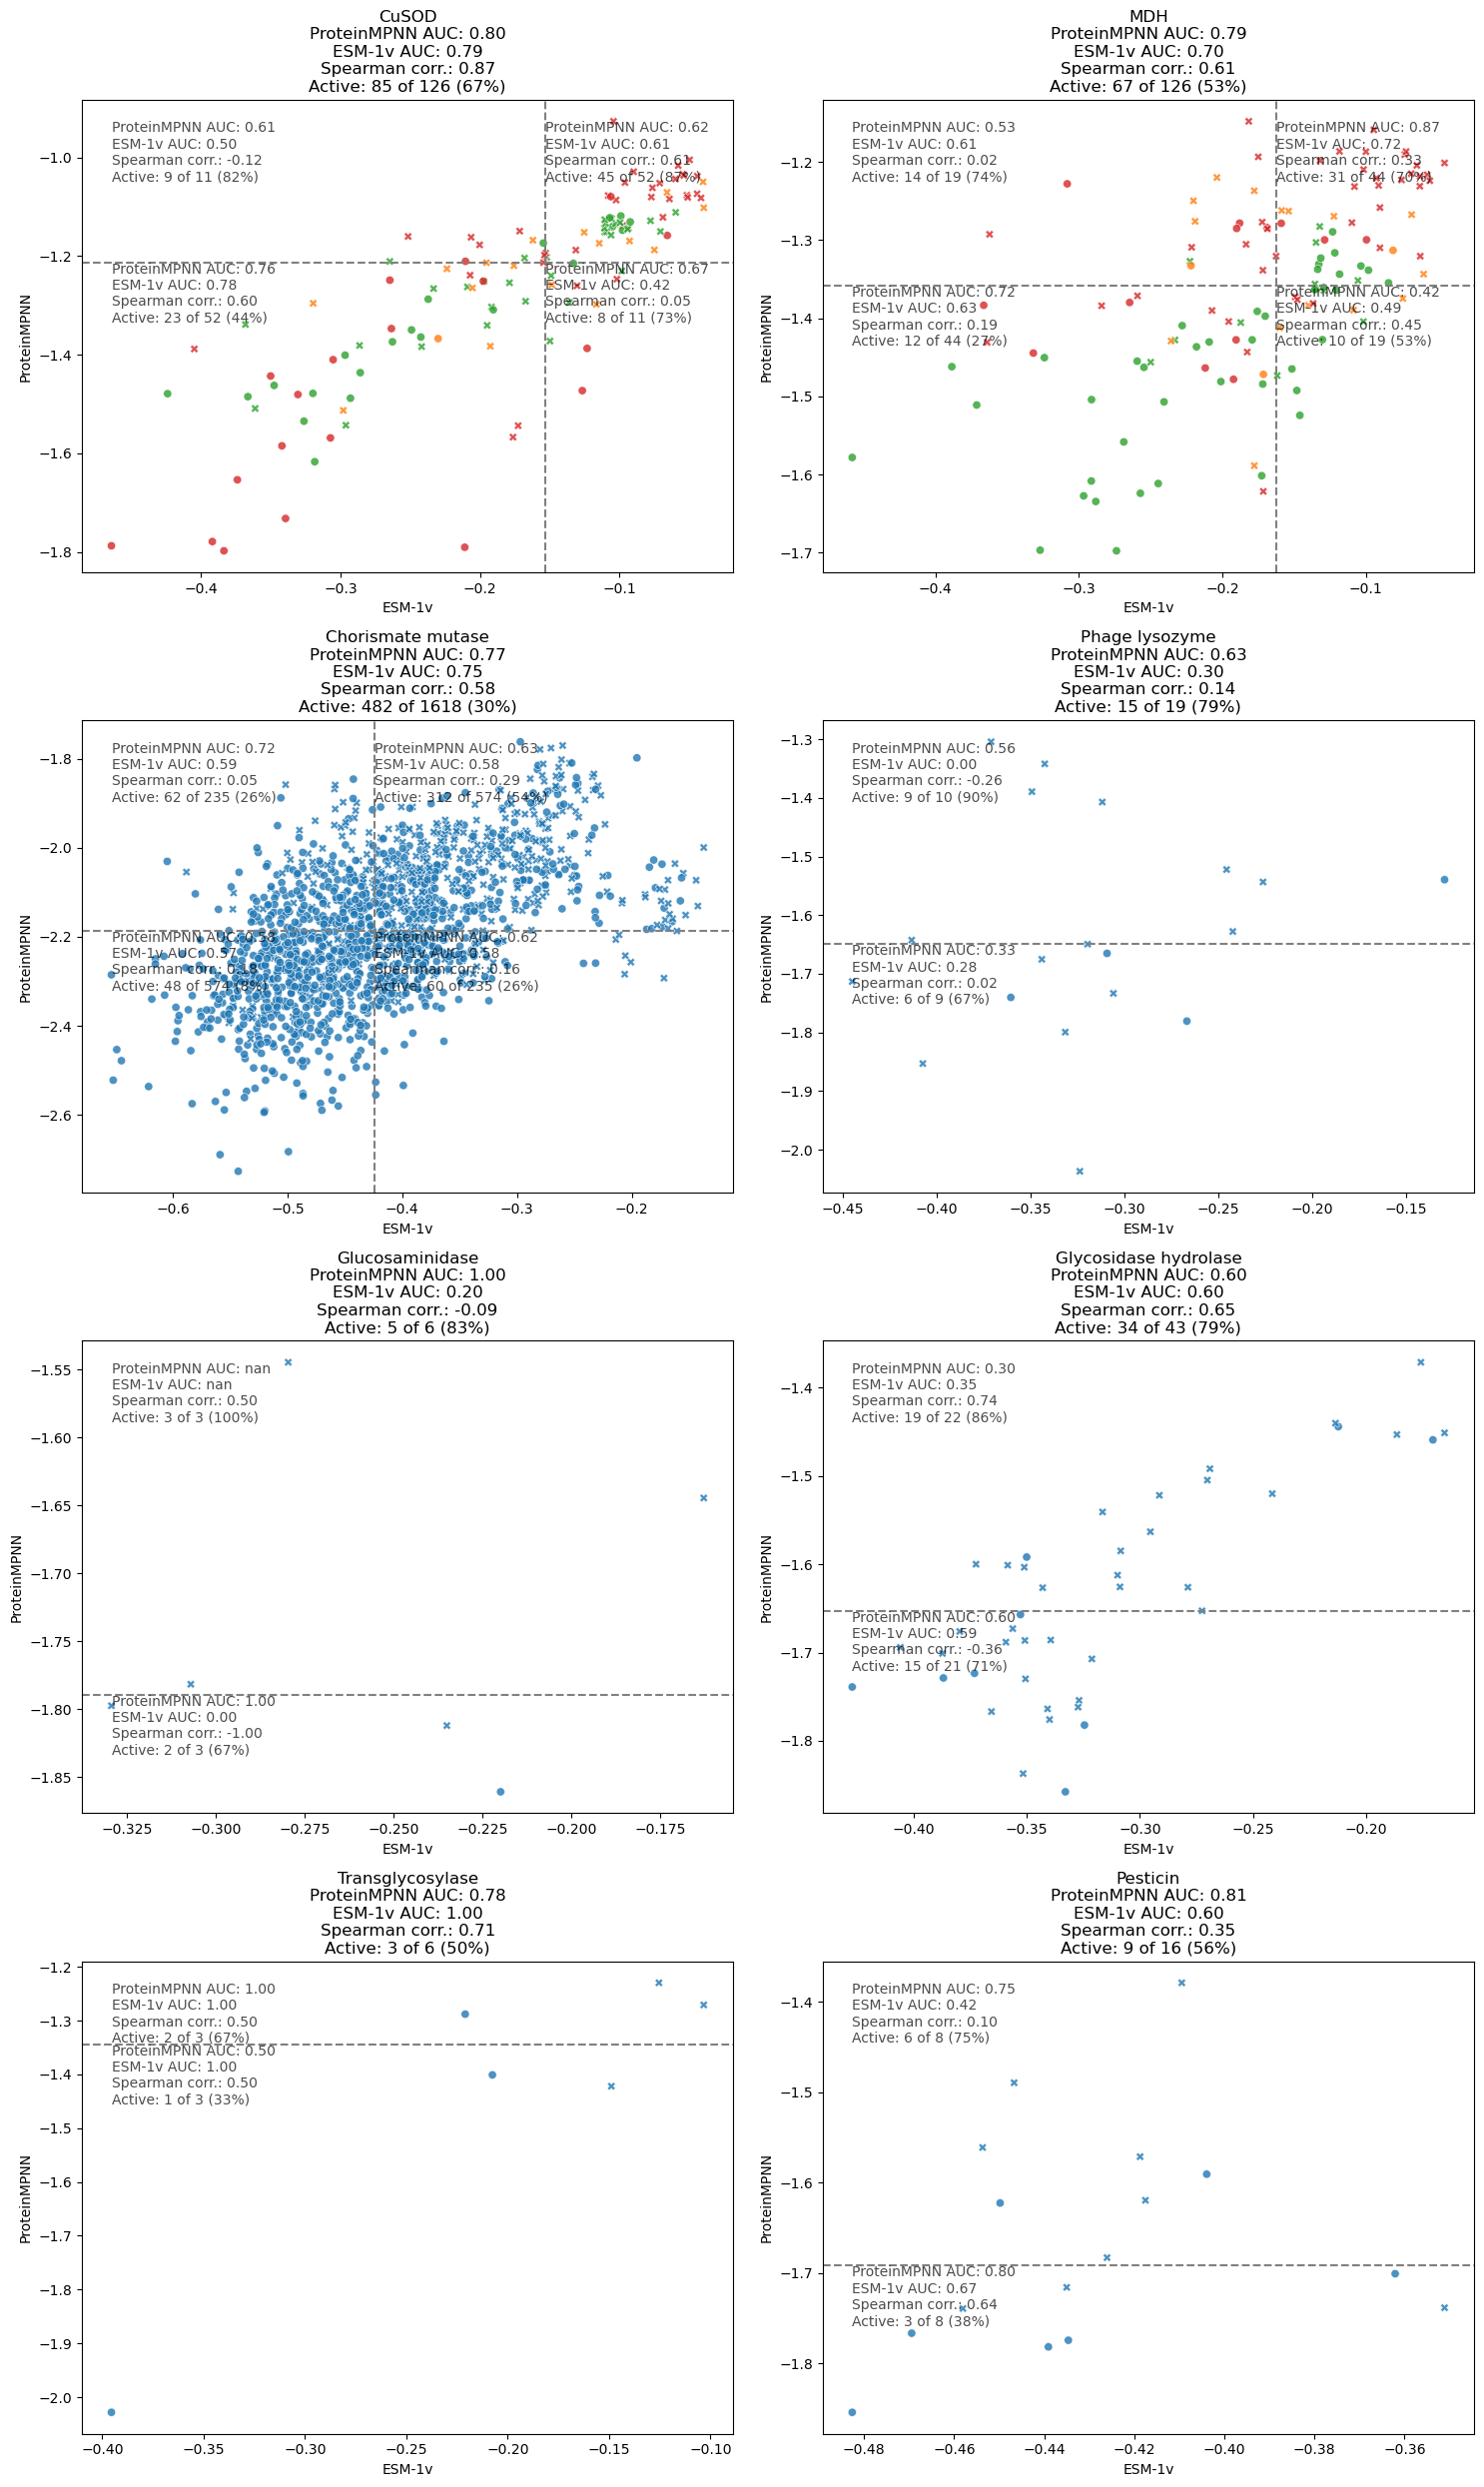

In [15]:
fig, axes = plt.subplots(4, 2, sharex=False, sharey=False, figsize=(15,25))
axes = axes.flat

selected_df = experimentally_tested_metrics[(experimentally_tested_metrics["Round"] == "round3") | (experimentally_tested_metrics["Round"] == "round2") & (experimentally_tested_metrics["Model"] != "pre-test")& (experimentally_tested_metrics["Model"] != "test")].copy()
selected_df["Round"] = selected_df["Round"].str.replace("3","2")
selected_df["Model"] = selected_df["Model"].replace({'GAN-passing': "GAN", "ESM-MSA-control":"ESM-MSA", "GAN-control":"GAN", "ESM-MSA-passing":"ESM-MSA"})
#selected_df = selected_df.merge(generated, how="left", on=("id","Family","Round","Model"))

selected_df["Pass"] = selected_df.apply(pass_filter, axis=1)

for i, family in enumerate(("CuSOD", "MDH")):
    family_df = selected_df[selected_df["Family"] == family]
    plot_quarters(family_df, ax = axes[i], title_base=family)
    
plot_quarters(CM_df[(CM_df["Model"] == "BmDCA")], ax=axes[2], title_base="Chorismate mutase", hue_order=None)

families=("Phage lysozyme", "Glucosaminidase", "Glycosidase hydrolase", "Transglycosylase", "Pesticin")
for ax_num, family in enumerate(families):
    l_df = pd.DataFrame(lysozyme_df[(lysozyme_df["Family_name"] == family) & (lysozyme_df["Model"] == "progen")])
    plot_halves(l_df, ax=axes[3+ax_num], title_base=family, hue_order=None)

plt.tight_layout()

fig.savefig("quadrant_AUCs_lys_halves.svg")

/home/sean/miniconda3/envs/protein_scoring/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sean/miniconda3/envs/protein_scoring/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/sean/miniconda3/envs/protein_scoring/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/home/sean/miniconda3/envs/protein_scoring/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/home/sean/miniconda3/envs/protein_scoring/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWa

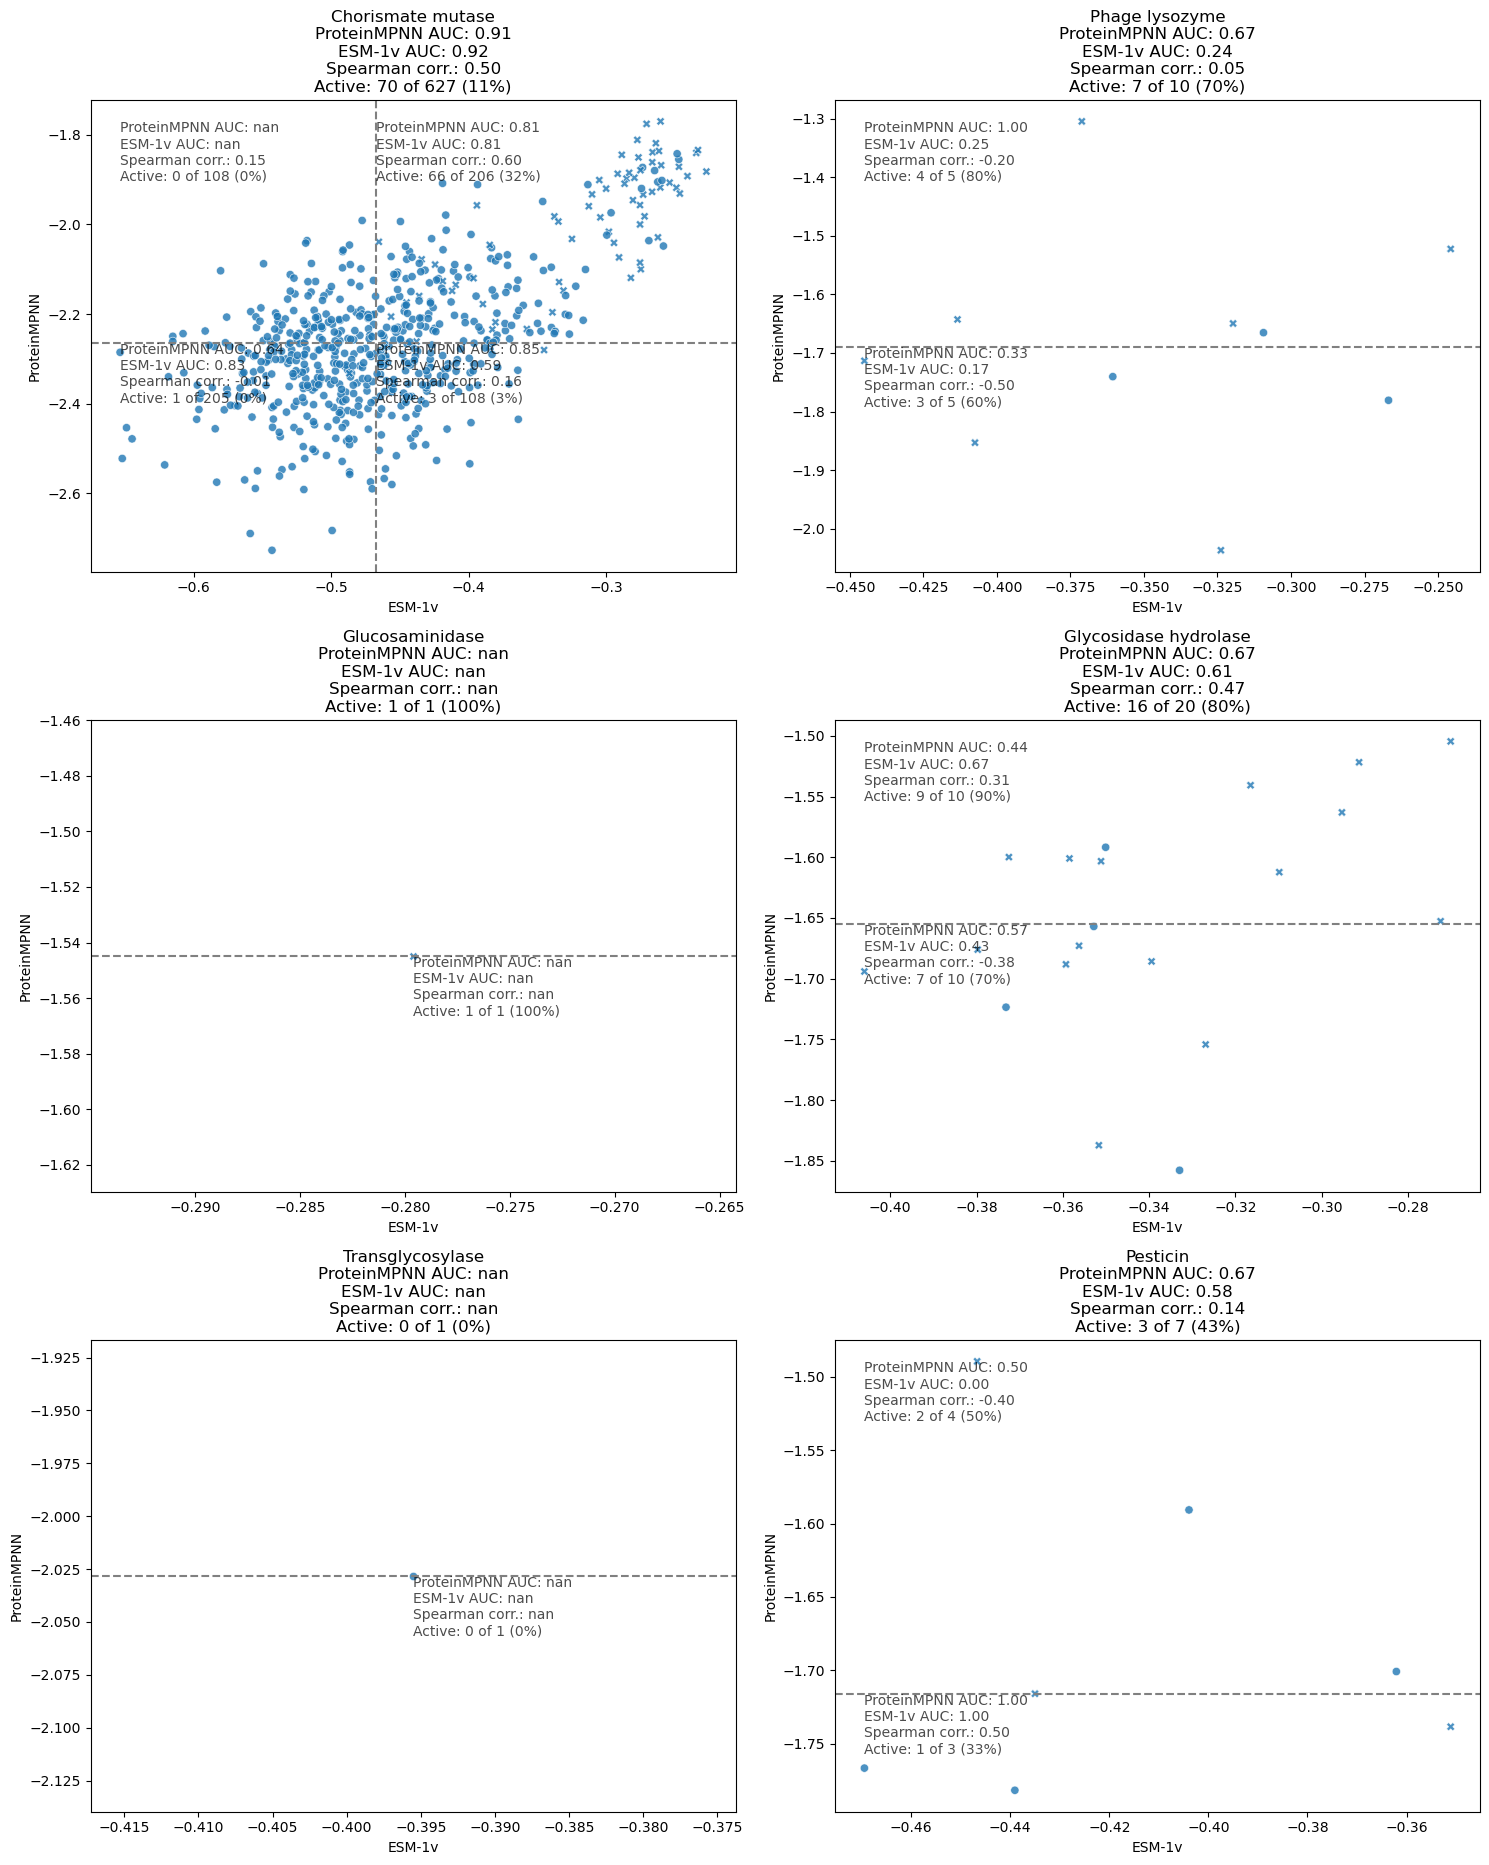

In [16]:
fig, axes = plt.subplots(3, 2, sharex=False, sharey=False, figsize=(15,18.75))
axes = axes.flat

    
plot_quarters(CM_df[(CM_df["Model"] == "BmDCA") & (CM_df["top ID"] < 0.7)], ax=axes[0], title_base="Chorismate mutase", hue_order=None)

families=("Phage lysozyme", "Glucosaminidase", "Glycosidase hydrolase", "Transglycosylase", "Pesticin")
for ax_num, family in enumerate(families):
    l_df = pd.DataFrame(lysozyme_df[(lysozyme_df["Family_name"] == family) & (lysozyme_df["Model"] == "progen") & (lysozyme_df["max_ID_to_any_natural"] < 0.7)])
    plot_halves(l_df, ax=axes[1+ax_num], title_base=family, hue_order=None)

plt.tight_layout()

fig.savefig("quadrant_AUCs_lys_halves_under_70.svg")

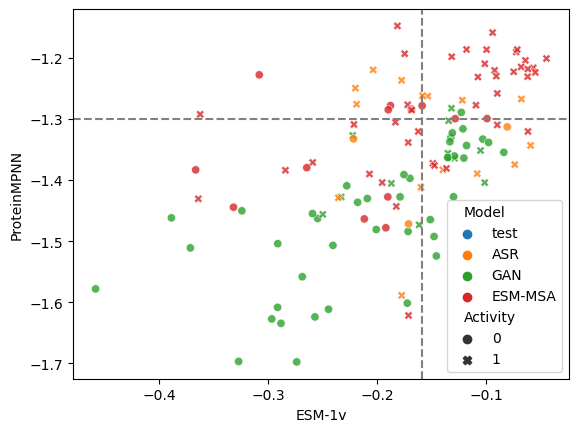

In [17]:
quantiles = [0.5] #[0.25,0.5,0.75]
family="MDH"

sns.scatterplot(x="ESM-1v", y="ProteinMPNN", style="Activity",  hue="Model", style_order=[0,1], alpha=0.8, hue_order=MODEL_HUE_ORDER, data=selected_df[selected_df["Family"] == family])

for v_quant in selected_df["ProteinMPNN"].quantile(quantiles):
    plt.axhline(v_quant, color="grey", linestyle="--")
    
for h_quant in selected_df["ESM-1v"].quantile(quantiles):
    plt.axvline(h_quant, color="grey", linestyle="--")


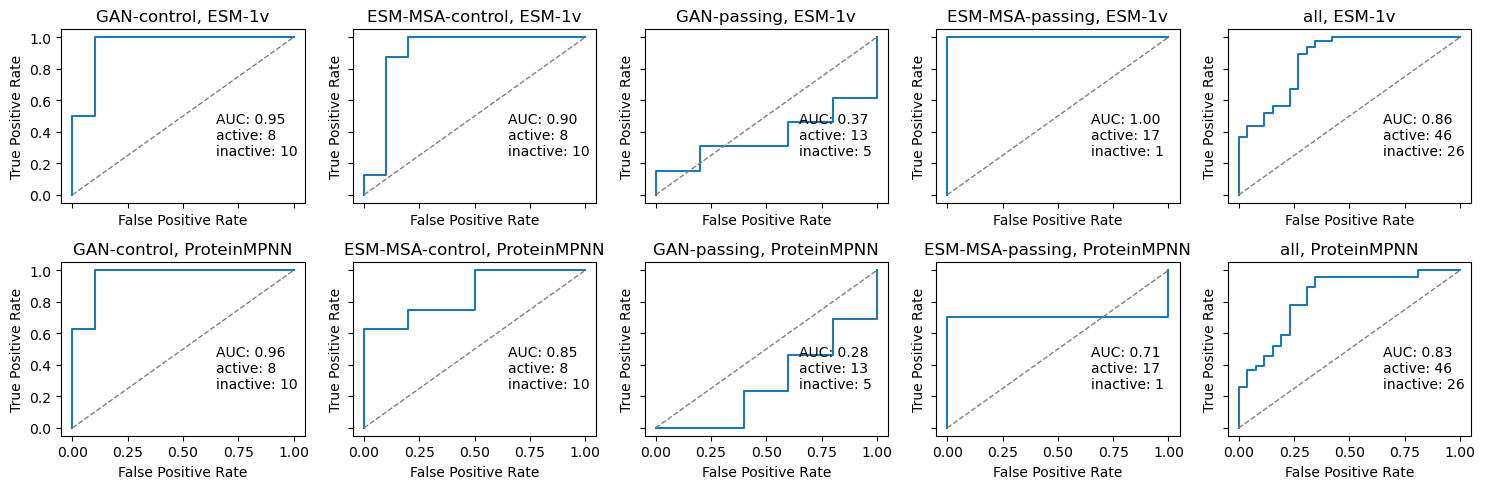

In [19]:
fig, axes = plt.subplots(len(METRICS_OF_INTEREST), 5, sharex=True, sharey='row', figsize=(15,5))
family = "CuSOD"

for model_i, model in enumerate([("GAN-control",), ("ESM-MSA-control",), ("GAN-passing",), ("ESM-MSA-passing",), ("GAN-control", "ESM-MSA-control", "GAN-passing", "ESM-MSA-passing")]):
    metric_i = 0
    df = experimentally_tested_metrics[
    (experimentally_tested_metrics['Round'] == 'round3') &
    (experimentally_tested_metrics['Model'].isin(model)) & 
    (experimentally_tested_metrics['Family'] == family)
    ]
    
    if model == ("GAN-control", "ESM-MSA-control", "GAN-passing", "ESM-MSA-passing"):
        model = "all"
    else:
        model = model[0]
    
    for metric in METRICS_OF_INTEREST:
            
        fpr, tpr, _ = roc_curve( df["Activity"], df[metric])
        auc_value = auc(fpr, tpr)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
        roc_display.plot(axes[metric_i, model_i])
        lw=1
        roc_display.ax_.plot([0, 1], [0, 1], color="gray", lw=lw, linestyle="--")
        metric_i += 1
        num_active = df["Activity"].sum()
        num_inactive = df["Activity"].size - num_active
        roc_display.ax_.text(.65,.25, f"AUC: {auc_value:0.2f}\nactive: {num_active}\ninactive: {num_inactive}")
        roc_display.ax_.set_title(f"{model}, {metric}")
        #ax.get_legend().remove()
plt.tight_layout()

# plt.savefig(f"{outdir}/round2_supplemental_AUCs_{family}.png", dpi=300)

/home/sean/miniconda3/envs/protein_scoring/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/home/sean/miniconda3/envs/protein_scoring/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


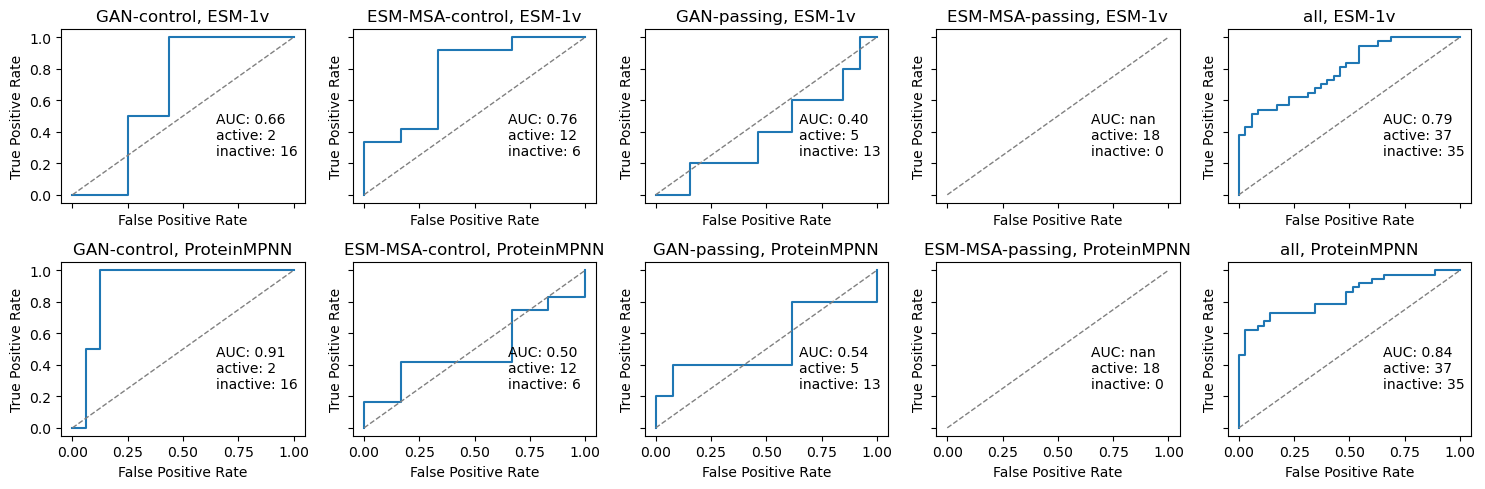

In [20]:
fig, axes = plt.subplots(len(METRICS_OF_INTEREST), 5, sharex=True, sharey='row', figsize=(15,5))
family = "MDH"

for model_i, model in enumerate([("GAN-control",), ("ESM-MSA-control",), ("GAN-passing",), ("ESM-MSA-passing",), ("GAN-control", "ESM-MSA-control", "GAN-passing", "ESM-MSA-passing")]):
    metric_i = 0
    df = experimentally_tested_metrics[
    (experimentally_tested_metrics['Round'] == 'round3') &
    (experimentally_tested_metrics['Model'].isin(model)) & 
    (experimentally_tested_metrics['Family'] == family)
    ]
    
    if model == ("GAN-control", "ESM-MSA-control", "GAN-passing", "ESM-MSA-passing"):
        model = "all"
    else:
        model = model[0]
    
    for metric in METRICS_OF_INTEREST:
            
        fpr, tpr, _ = roc_curve( df["Activity"], df[metric])
        auc_value = auc(fpr, tpr)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
        roc_display.plot(axes[metric_i, model_i])
        lw=1
        roc_display.ax_.plot([0, 1], [0, 1], color="gray", lw=lw, linestyle="--")
        metric_i += 1
        num_active = df["Activity"].sum()
        num_inactive = df["Activity"].size - num_active
        roc_display.ax_.text(.65,.25, f"AUC: {auc_value:0.2f}\nactive: {num_active}\ninactive: {num_inactive}")
        roc_display.ax_.set_title(f"{model}, {metric}")
        #ax.get_legend().remove()
plt.tight_layout()
